In [18]:
import matplotlib.pyplot as plt
import pennylane as qml
import jax
import jax.numpy as jnp
import pickle
# from models.controlled_rotations import *
# from models.encodings import *

with open(f"../trained_models/2nd_run/trained_weights_exponential_degree10_seed99", "rb") as f:
    all_trained_weights = pickle.load(f)

for w, n, d in all_trained_weights:
    if n == "basic_ry_rxx_rz" and d == 54:
        trained_weights = w

def minmax_scaler(y):
    # Scale y to [0, 1]
    y_min = jnp.min(y)
    y_max = jnp.max(y)
    y_scaled = (y - y_min) / (y_max - y_min)
    return y_scaled

x_raw = jnp.linspace(-12, 12, 400)
x = minmax_scaler(x_raw) * 2 * jnp.pi
x_inbetween = jnp.array([])

for i in range(1, 399, 2):
    x_inbetween = jnp.append(x_inbetween, x[i])

key0 = jax.random.PRNGKey(42)
x_test = jax.random.choice(key0, x_inbetween, shape=(50,), replace=False)
len(x_test), len(trained_weights.flatten())

(50, 54)

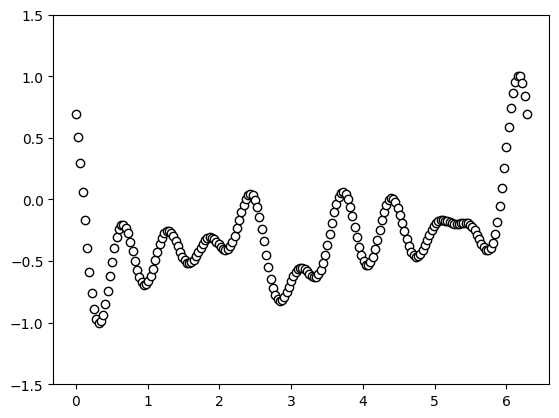

In [19]:
coeffs = [
    (1.29 + 1.13j),  # c_1
    (0.43 + 0.89j),  # c_2
    (1.97 + 1.03j),  # c_3
    (0.17 + 0.59j),  # c_4
    (1.71 + 1.41j),  # c_5
    (0.61 + 0.37j),  # c_6
    (1.19 + 1.67j),  # c_7
    (0.73 + 1.61j),  # c_8
    (0.23 + 0.47j),  # c_9
    (1.83 + 0.83j),  # c_10
]

c0 = 0.0
scaling = 1
n_qubits = 3

def target_function(x):
    res = c0
    for idx, c in enumerate(coeffs):
        exponent = scaling * (idx + 1) * x * 1j
        conj_c = jnp.conjugate(c)
        res += c * jnp.exp(exponent) + conj_c * jnp.exp(-exponent)
    return jnp.real(res)

x_raw = jnp.linspace(-12, 12, 200)
x = minmax_scaler(x_raw) * 2 * jnp.pi
target_y = jax.vmap(target_function)(x)

target = minmax_scaler(target_y) * 2 - 1

# plt.plot(x, target_y, c="black")
plt.scatter(x, target, facecolor="white", edgecolor="black")
plt.ylim(-1.5, 1.5)
plt.show()

In [8]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Clear any existing accounts
try:
    QiskitRuntimeService.delete_account()
except:
    pass

token = ""
crn = ""

service = QiskitRuntimeService.save_account(token=token, instance=crn, set_as_default=True, overwrite=True)

# Test connection
service = QiskitRuntimeService()
print("Connection successful!")
print("Available backends:", [b.name for b in service.backends()])

backend = service.backend("ibm_marrakesh")

# Check if it's currently available
print(f"Operational: {backend.status().operational}")
print(f"Pending jobs: {backend.status().pending_jobs}")

# Get qubit properties
print(f"Number of qubits: {backend.num_qubits}")
device = qml.device(
    'qiskit.remote',
    wires=n_qubits,
    backend=backend,  # ⚠️ Must be backend object, not string!
    shots=1024,  # More shots = better statistics
    optimization_level=3,  # Higher optimization (0-3)
    resilience_level=2,  # Error mitigation level (0-2)
    seed_transpiler=42,  # Reproducible transpilation
    # Additional runtime options:
    #dynamical_decoupling={'enable': True},  # Dynamical decoupling
    #twirling={'enable_gates': True},         # Gate twirling
    # Additional transpiler options:
    #routing_method='sabre',             # Routing algorithm
    #layout_method='sabre',              # Initial layout method
    #translation_method='translator',    # Gate translation method
)

Connection successful!
Available backends: ['ibm_brisbane', 'ibm_fez', 'ibm_torino', 'ibm_pittsburgh', 'ibm_marrakesh', 'ibm_kingston']
Operational: True
Pending jobs: 4
Number of qubits: 156


In [9]:
def basic_ry_rxx_rz(n_qubits, trainable_layers, scaling):
    # device = qml.device("default.qubit", wires=n_qubits)
    # num_wx = 2
    # layer_size = 3 * n_qubits
    # weights = jax.random.uniform(random_key1, shape=(num_wx, trainable_layers, layer_size), minval=0, maxval=2 * jnp.pi)

    def S(x):
        """encoding block"""
        for w in range(n_qubits):
            qml.RX((scaling**w) * x, wires=w)

    def W(theta):
        """
        train block
        RY and RZ with RZZ basic entangling layers
        """
        idx = 0
        # RY to each qubit
        for i in range(n_qubits):
            qml.RY(theta[idx], wires=i)
            idx += 1

        # Ring of RZZ
        for i in range(n_qubits):
            j = (i + 1) % n_qubits
            qml.IsingXX(theta[idx], wires=[i, j])
            idx += 1

        # RZ to each qubit
        for i in range(n_qubits):
            qml.RZ(theta[idx], wires=i)
            idx += 1

    @qml.qnode(device)
    def model(data, weights):

        for layer in range(trainable_layers):
            W(weights[0][layer])

        S(data)

        for layer in range(trainable_layers):
            W(weights[1][layer])

        return qml.expval(qml.PauliZ(0))

    return model, "basic_ry_rxx_rz"

C:\Users\test\AppData\Local\Temp\ipykernel_20600\1729337051.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


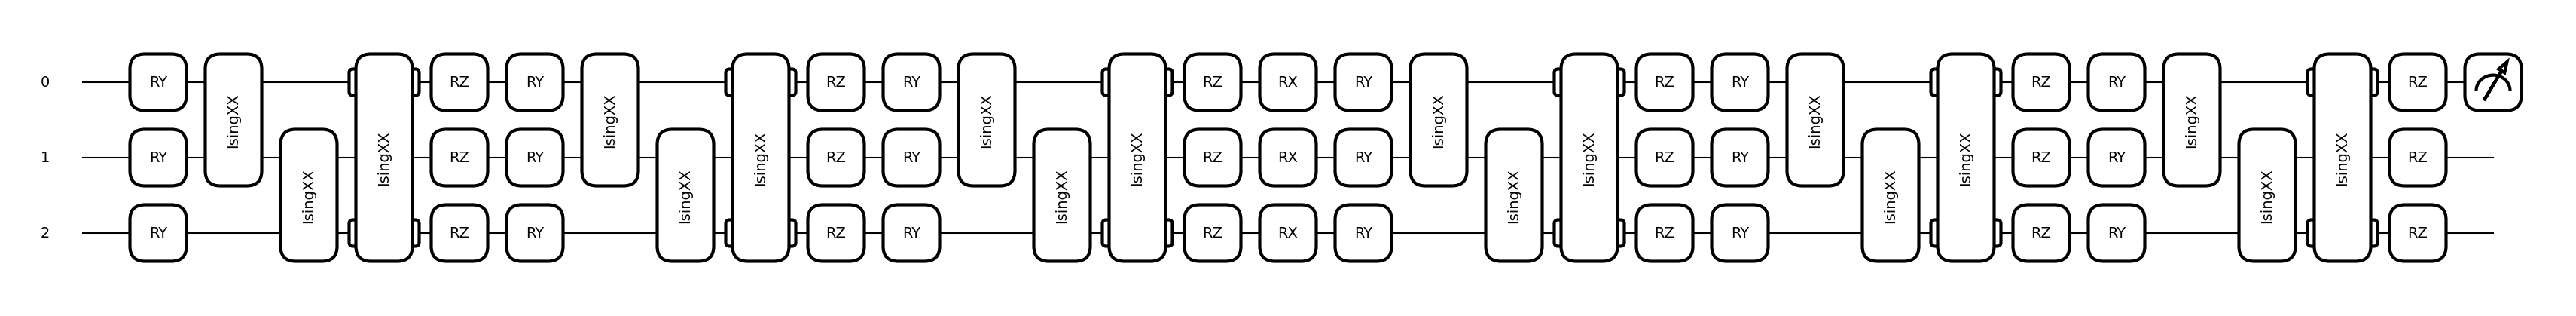

In [10]:
qm, name = basic_ry_rxx_rz(n_qubits, 3, 3)
fig, ax = qml.draw_mpl(qm)(jnp.array([0.0, 0.0]), trained_weights)
fig.show()

In [22]:
def r2_score(y_true, y_pred):
    ss_resid = jnp.sum((y_true - y_pred) ** 2)
    ss_total = jnp.sum((y_true - jnp.mean(y_true)) ** 2)
    return 1 - ss_resid / ss_total

test_target = jax.vmap(target_function)(x_test)
test_target = minmax_scaler(test_target) * 2 - 1

In [ ]:

predictions = qm(x_test, trained_weights)

In [23]:

r2 = r2_score(test_target, predictions)
print(r2)

0.9546723


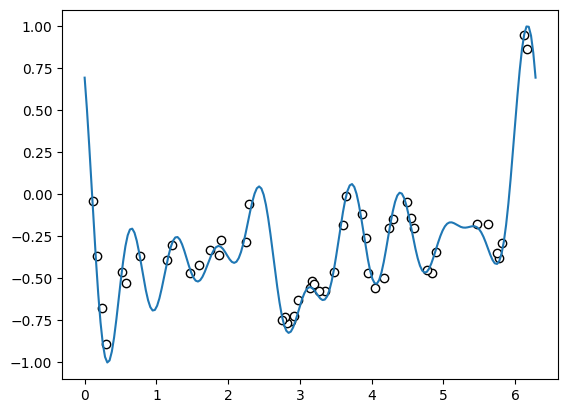

In [20]:
plt.plot(x, target)
plt.scatter(x_test, predictions, facecolor="white", edgecolor="black")
plt.show()

In [13]:
# predictions_simulated = qm2(x_test, trained_weights)
# r2_simulated = r2_score(test_target, predictions_simulated)
# print(r2, r2_simulated)

In [14]:
# plt.plot(x, target)
# plt.scatter(x_test, predictions_simulated, facecolor="white", edgecolor="black")
# plt.show()

In [24]:
def param_count(pytree):
    leaves = jax.tree_util.tree_leaves(pytree)
    return int(sum(jnp.size(leaf) for leaf in leaves))

params = param_count(trained_weights)

predictions_r2score = (predictions, r2)

with open(f"real_predictions/predictions_r2scores_{name}_{n_qubits}qubits_{params}params", "wb") as f:
    pickle.dump(predictions_r2score, f)